In [1]:
import os 
os.chdir("/home/canyon/Bus-Weather-Impacts")
from src.utils import *
import pandas as pd
import os
import osmnx as ox
import numpy as np
import geopandas as gpd
import networkx as nx
from sklearn.neighbors import KDTree
import numpy as np
import requests
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.02f}'.format)
from geopy.distance import geodesic
from shapely.ops import linemerge
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_columns', None)
import contextily as ctx
from src.api import parse_zipped_gtfs
import matplotlib.pyplot as plt
from src.gtfs_segments import GTFS_shape_processor
from shapely.geometry import Point
from plotnine import *
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

## Prep GTFS

In [2]:
gtfs_speed = read_speeds_between_dates("2023-09-18", "2023-10-15").query("speed_mph < 70 & speed_mph > 0")
full_trips = pd.read_parquet("/home/data/bus-weather/nyc_trip_shapes.parquet")
gtfs_speed = full_trips.merge(gtfs_speed)

In [150]:
segments = gpd.read_parquet("/home/data/bus-weather/bus_segments_2023_09_18.parquet")
ntas_url = "https://data.cityofnewyork.us/api/geospatial/d3qk-pfyz?method=export&format=GeoJSON"
ntas = gpd.read_file(ntas_url).to_crs(2263)
seg_ntas = segments.overlay(ntas)
seg_ntas["seg_length"] = seg_ntas.length
seg_ntas = seg_ntas.sort_values(["shape_id", "stop_id", "prev_stop_id", "seg_length"]).drop_duplicates(["shape_id", "stop_id", "prev_stop_id"], keep = "first")
seg_ntas = seg_ntas[["shape_id", "stop_id", "prev_stop_id", "boroname", "ntaname", "ntacode"]]
segments = segments.merge(seg_ntas, how = "left")
segments = segments.merge(gtfs_speed[["shape_id", "route_id"]].drop_duplicates())

In [5]:
gtfs_speed["date"] = gtfs_speed.interpolated_time.dt.date.astype(str)
gtfs_speed["hour"] = gtfs_speed.interpolated_time.dt.hour.astype(int)
gtfs_speed["day_of_week"] = gtfs_speed["interpolated_time"].dt.dayofweek
gtfs_speed = gtfs_speed.merge(segments[["shape_id", "stop_id", "prev_stop_id", "boroname", "ntaname", "ntacode"]])

## Prep Floodnet

In [6]:
floodnet_hourly = pd.read_parquet("/home/data/bus-weather/Floodnet_hourly_average_Sep28_to_Sep30.parquet")
floodnet_locations = pd.read_parquet("/home/data/bus-weather/Floodnet_locations.parquet")

In [7]:
floodnet_hourly["hour"] = floodnet_hourly["time_dh"].dt.hour.astype(int)
floodnet_hourly["date"] = floodnet_hourly["time_dh"].dt.date.astype(str)
floodnet_hourly["time_of_day"] = floodnet_hourly["hour"].apply(time_of_day)
floodnet_hourly["flood_depth_category"] = pd.cut(floodnet_hourly["avg_flood_inches"], bins = [-1, 0, 5, 15, 1000], labels = ["No flooding", "0 - 5 inches", "5 - 15 inches", "15+ inches"], ordered = True)

In [143]:
floodnet_locations['geometry'] = floodnet_locations['coordinates'].apply(lambda x: Point(x[1], x[0]))
floodnet_gdf = gpd.GeoDataFrame(floodnet_locations, geometry='geometry', crs = 4326)[["name", "geometry"]].to_crs(2263)
floodnet_gdf["geometry"] = floodnet_gdf.geometry.buffer(350)
floodnet_gdf = floodnet_gdf.merge(floodnet_hourly.groupby("name")["avg_flood_inches"].max().reset_index())

## Merge floodnet and GFTFS

In [153]:
segments.query("route_id == 'B62'").shape_id.value_counts()

shape_id
B620014    47
B620017    44
Name: count, dtype: int64

In [188]:
B61 = gtfs_speed.query("shape_id == 'B620014'")

In [189]:
B61_norms = B61.query("day_of_week.isin([1,2,3,4,5]) & date != '2023-09-29'").groupby(["shape_id", "stop_id", "prev_stop_id", "hour", "date"]).agg(speed_mph = ("speed_mph", "mean"),
                                             total_trips = ("unique_trip_id", "nunique")).reset_index().groupby(["stop_id", "prev_stop_id", "hour"]).agg(speed_mph = ("speed_mph", "mean"),
                                             total_trips = ("total_trips", "mean"), 
                                             speed_sd = ("speed_mph", "std"),
                                             trips_sd = ("total_trips", "std")).reset_index()

B61_flood= B61.query("date == '2023-09-29'").groupby(["shape_id", "stop_id", "prev_stop_id", "hour", "date"]).agg(speed_mph_flood = ("speed_mph", "mean"),
                                             total_trips_flood = ("unique_trip_id", "nunique")).reset_index()

In [190]:
B61_comp = B61_flood.merge(B61_norms)
B61_comp["speed_diff"] =  B61_comp["speed_mph_flood"]  - B61_comp["speed_mph"] 
B61_comp["speed_diff_pct"] = (B61_comp["speed_diff"] / B61_comp["speed_mph"]) * 100

In [191]:
B61_comp.merge(segments.overlay(floodnet_gdf[["name", "geometry"]].merge(floodnet_hourly)))

,shape_id,stop_id,prev_stop_id,hour,date,speed_mph_flood,total_trips_flood,speed_mph,total_trips,speed_sd,trips_sd,speed_diff,speed_diff_pct,stop_sequence,stop_name,prev_stop_name,projected_position,prev_projected_position,segment_length,boroname,ntaname,ntacode,route_id,name,avg_flood_inches,time_dh,time_of_day,flood_depth_category,geometry
0,B620014,306763,303813,0,2023-09-29,7.957123,3,8.151500,2.736842,2.751255,0.805682,-0.194377,-2.384554,17,KENT AV/WILLIAMSBURG ST E,CLASSON AV/FLUSHING AV,15051.159806,14279.478150,771.681657,Brooklyn,Williamsburg,BK72,B62,BK - Kent Ave/Wallabout St,0.000000,2023-09-29 00:00:00,Night,No flooding,"LINESTRING (994870.732 193900.945, 994881.386 ..."
1,B620014,306763,303813,1,2023-09-29,8.094561,1,8.205521,1.117647,2.508414,0.332106,-0.110960,-1.352263,17,KENT AV/WILLIAMSBURG ST E,CLASSON AV/FLUSHING AV,15051.159806,14279.478150,771.681657,Brooklyn,Williamsburg,BK72,B62,BK - Kent Ave/Wallabout St,0.000000,2023-09-29 01:00:00,Night,No flooding,"LINESTRING (994870.732 193900.945, 994881.386 ..."
2,B620014,306763,303813,2,2023-09-29,6.745467,1,9.457814,1.000000,8.103406,0.000000,-2.712347,-28.678367,17,KENT AV/WILLIAMSBURG ST E,CLASSON AV/FLUSHING AV,15051.159806,14279.478150,771.681657,Brooklyn,Williamsburg,BK72,B62,BK - Kent Ave/Wallabout St,0.000000,2023-09-29 02:00:00,Night,No flooding,"LINESTRING (994870.732 193900.945, 994881.386 ..."
3,B620014,306763,303813,3,2023-09-29,6.416420,1,13.504411,1.000000,6.145799,0.000000,-7.087991,-52.486488,17,KENT AV/WILLIAMSBURG ST E,CLASSON AV/FLUSHING AV,15051.159806,14279.478150,771.681657,Brooklyn,Williamsburg,BK72,B62,BK - Kent Ave/Wallabout St,0.000000,2023-09-29 03:00:00,Night,No flooding,"LINESTRING (994870.732 193900.945, 994881.386 ..."
4,B620014,306763,303813,4,2023-09-29,14.124437,3,12.799406,2.842105,3.905015,1.067872,1.325031,10.352287,17,KENT AV/WILLIAMSBURG ST E,CLASSON AV/FLUSHING AV,15051.159806,14279.478150,771.681657,Brooklyn,Williamsburg,BK72,B62,BK - Kent Ave/Wallabout St,0.000000,2023-09-29 04:00:00,Night,No flooding,"LINESTRING (994870.732 193900.945, 994881.386 ..."
5,B620014,306763,303813,5,2023-09-29,9.931716,4,11.077399,3.210526,3.157308,0.787327,-1.145683,-10.342528,17,KENT AV/WILLIAMSBURG ST E,CLASSON AV/FLUSHING AV,15051.159806,14279.478150,771.681657,Brooklyn,Williamsburg,BK72,B62,BK - Kent Ave/Wallabout St,0.000000,2023-09-29 05:00:00,Morning,No flooding,"LINESTRING (994870.732 193900.945, 994881.386 ..."
6,B620014,306763,303813,6,2023-09-29,11.495795,4,8.939786,4.052632,2.190039,1.129094,2.556009,28.591393,17,KENT AV/WILLIAMSBURG ST E,CLASSON AV/FLUSHING AV,15051.159806,14279.478150,771.681657,Brooklyn,Williamsburg,BK72,B62,BK - Kent Ave/Wallabout St,0.000000,2023-09-29 06:00:00,Morning,No flooding,"LINESTRING (994870.732 193900.945, 994881.386 ..."
7,B620014,306763,303813,7,2023-09-29,8.195730,4,9.597941,4.421053,3.472659,1.387075,-1.402211,-14.609502,17,KENT AV/WILLIAMSBURG ST E,CLASSON AV/FLUSHING AV,15051.159806,14279.478150,771.681657,Brooklyn,Williamsburg,BK72,B62,BK - Kent Ave/Wallabout St,0.000000,2023-09-29 07:00:00,Morning,No flooding,"LINESTRING (994870.732 193900.945, 994881.386 ..."
8,B620014,306763,303813,8,2023-09-29,2.470305,2,8.815392,6.105263,2.410535,2.183136,-6.345088,-71.977372,17,KENT AV/WILLIAMSBURG ST E,CLASSON AV/FLUSHING AV,15051.159806,14279.478150,771.681657,Brooklyn,Williamsburg,BK72,B62,BK - Kent Ave/Wallabout St,0.000000,2023-09-29 08:00:00,Morning,No flooding,"LINESTRING (994870.732 193900.945, 994881.386 ..."
9,B620014,306763,303813,10,2023-09-29,3.835225,8,5.717387,3.000000,2.597028,1.054093,-1.882162,-32.919964,17,KENT AV/WILLIAMSBURG ST E,CLASSON AV/FLUSHING AV,15051.159806,14279.478150,771.681657,Brooklyn,Williamsburg,BK72,B62,BK - Kent Ave/Wallabout St,0.000000,2023-09-29 10:00:00,Morning,No flooding,"LINESTRING (994870.732 193900.945, 994881.386 ..."


In [ ]:
# Create a plot with the 'diff_pct' column from the merged GeoDataFrame
fig, ax = plt.subplots(figsize=(20, 20))  # Set the plot size

segments.merge(B61_norms.query('hour == 13')).plot(column="speed_mph", ax=ax, legend=True, linewidth = 5)
floodnet_gdf.query("name == 'BK - Kent Ave/Wallabout St'").head(1).plot(ax = ax, color = "red")
# Add a basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=ntas.crs)

# Show the plot
plt.show()


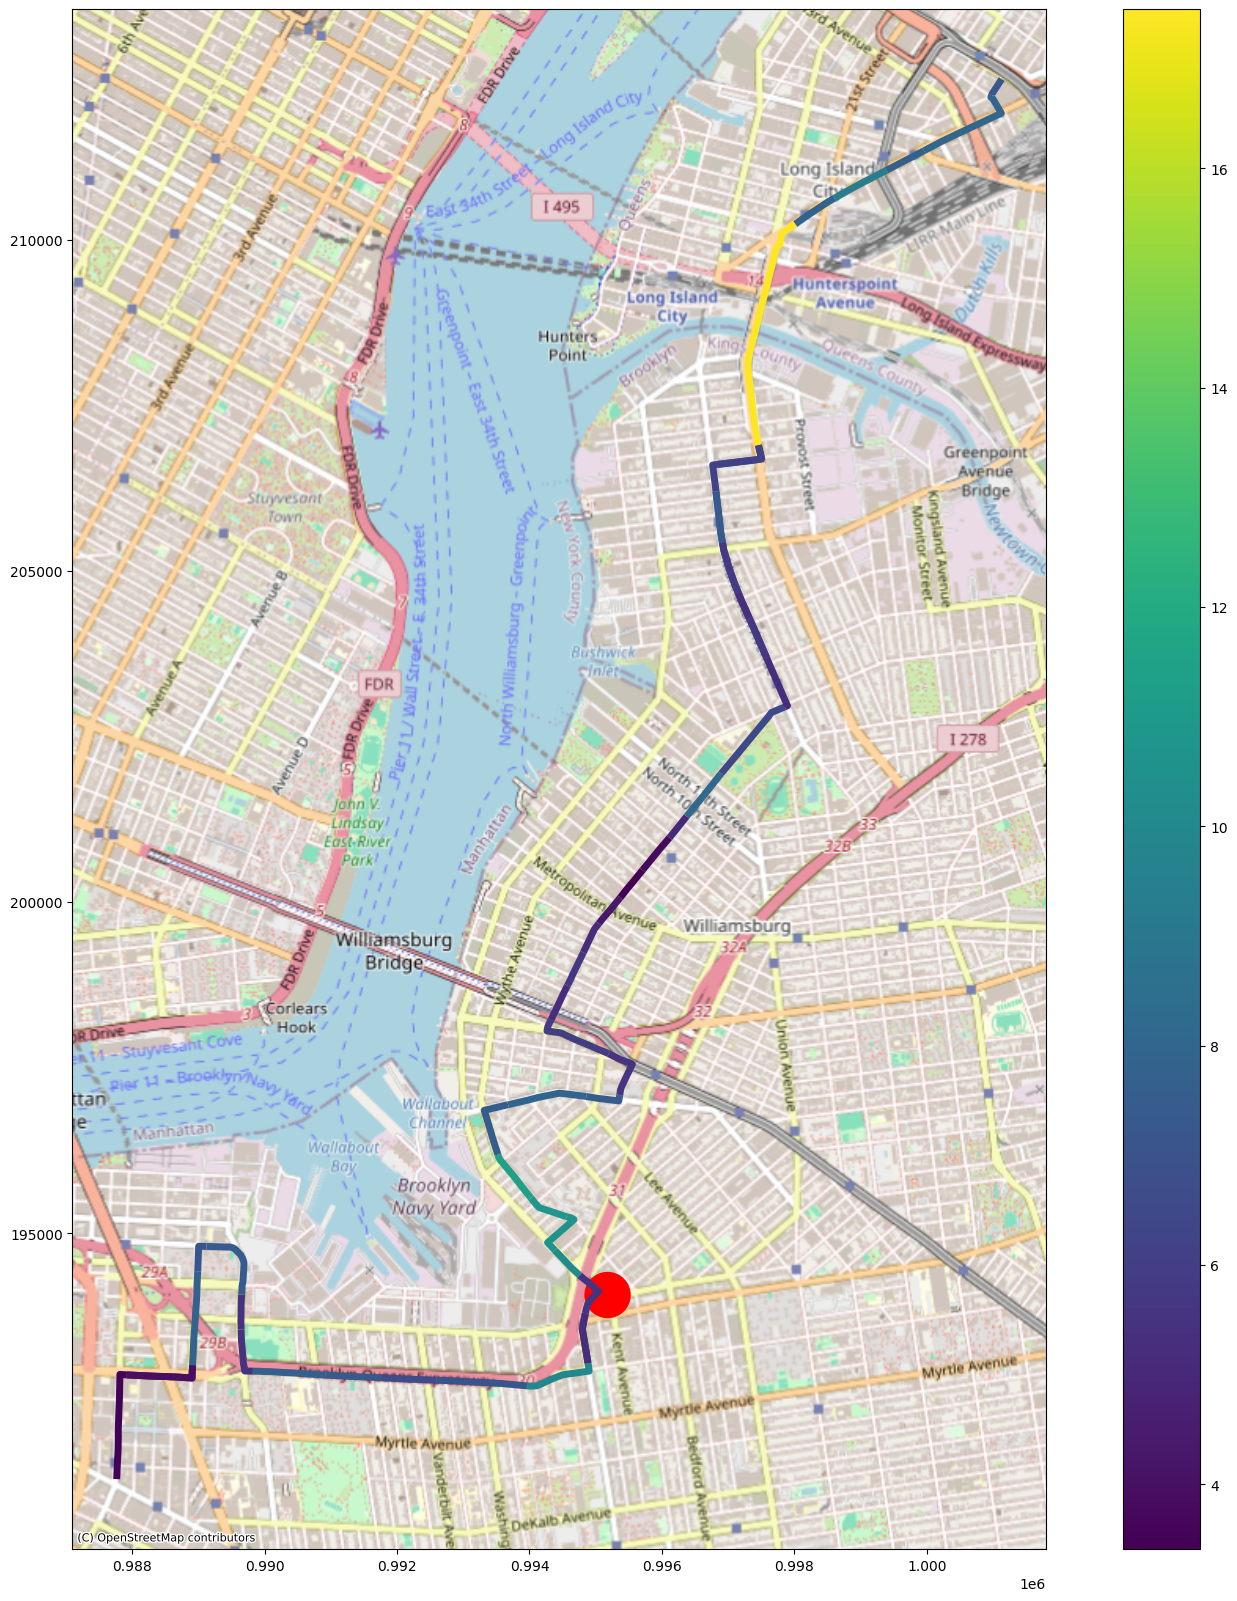

In [168]:
# Create a plot with the 'diff_pct' column from the merged GeoDataFrame
fig, ax = plt.subplots(figsize=(20, 20))  # Set the plot size

segments.merge(B61_norms.query('hour == 13')).plot(column="speed_mph", ax=ax, legend=True, linewidth = 5)
floodnet_gdf.query("name == 'BK - Kent Ave/Wallabout St'").head(1).plot(ax = ax, color = "red")
# Add a basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=ntas.crs)

# Show the plot
plt.show()


In [229]:
seg_floodnet = segments.overlay(floodnet_gdf)
seg_floodnet["seg_length"] = seg_floodnet.length
seg_floodnet = seg_floodnet.sort_values(["shape_id", "stop_id", "prev_stop_id", "seg_length"]).drop_duplicates(["shape_id", "stop_id", "prev_stop_id"], keep = "first")
seg_floodnet = seg_floodnet[["shape_id", "stop_id", "prev_stop_id","name"]]
seg_floodnet = seg_floodnet.merge(floodnet_hourly)